In [1]:
# Import our dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow as tf
from sklearn.datasets import make_circles

X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, random_state=78)

# Loading data
file_path = Path("Resources/american_airline.csv")
df_flights = pd.read_csv(file_path)
df_flights.head()
df_flights_non_na = df_flights.dropna()

# Transforming y_circles to a vertical vector
y_circles = y_circles.reshape(-1, 1)

# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

/var/folders/p2/rs4sq3nx6y74n6d0b0rzzx380000gn/T/ipykernel_14344/1264406592.py:13: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv(file_path)


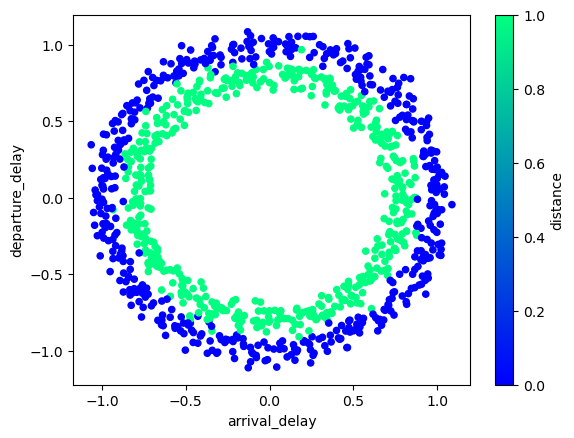

In [2]:
# Creating a DataFrame to plot the nonlinear dummy data
df_circles = pd.DataFrame(X_circles, columns=["arrival_delay", "departure_delay"])
df_circles["distance"] = y_circles

# Plot the nonlinear dummy data
df_circles.plot.scatter(x="arrival_delay",y="departure_delay", c="distance",colormap="winter")
plt.show()

In [3]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=5), activation=activation, input_dim=2))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [4]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

Using TensorFlow backend
Reloading Tuner from ./untitled_project/tuner0.json


In [5]:
 # Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [6]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 26, 'num_layers': 4, 'units_0': 26, 'units_1': 16, 'units_2': 16, 'units_3': 26, 'units_4': 1, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0052'}
{'activation': 'relu', 'first_units': 11, 'num_layers': 4, 'units_0': 11, 'units_1': 26, 'units_2': 11, 'units_3': 16, 'units_4': 11, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 11, 'num_layers': 3, 'units_0': 26, 'units_1': 16, 'units_2': 11, 'units_3': 16, 'units_4': 26, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [7]:
# Evaluate the top 3 models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.1007 - accuracy: 0.9760 - 81ms/epoch - 10ms/step
Loss: 0.10073907673358917, Accuracy: 0.9760000109672546
8/8 - 0s - loss: 0.1937 - accuracy: 0.9560 - 65ms/epoch - 8ms/step
Loss: 0.1936645209789276, Accuracy: 0.9559999704360962
8/8 - 0s - loss: 0.2073 - accuracy: 0.9560 - 61ms/epoch - 8ms/step
Loss: 0.20728491246700287, Accuracy: 0.9559999704360962


In [8]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 26,
 'num_layers': 4,
 'units_0': 26,
 'units_1': 16,
 'units_2': 16,
 'units_3': 26,
 'units_4': 1,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0052'}

In [9]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.1007 - accuracy: 0.9760 - 65ms/epoch - 8ms/step
Loss: 0.10073907673358917, Accuracy: 0.9760000109672546
